# MATH540 Project
# Aigerim Bazarkhanova and Alisher Iskakov
# Analyzing car accidents in Kazakhstan using machine learning

## Abstract

In this project we have applied machine learning techniques to classify different types of road traffic  accidents. We have obtained the data from the open sources and then prepared it for machine learning models. We have approached this problem by extracting several features, such as road conditions, light conditions (day, night), number of injured people etc. We have used several classifier models, which included logistic regression, SVM, kNN, LDA, QDA, neural networks and random forests. We have decided to implement logistic regression from scratch, while for the other models we have used the implementations from scikit-learn library. We then compared all these classifiers according to the following evaluation metrics: accuracy, precision, recall, and F1-score.

## Introduction

Every year car accidents cause the deaths of millions of people over the world, with a lot more injured people after the accidents. Kazakstan is not an exception in this situation. There are many factors that lead to accidents, which include driver condition (fatigue, intoxication), road conditions, weather conditions and a lot more. It is important to analyze these factors and to be able to reason about the causes of car accidents. In our work we have chosen to do exactly this by using the publicly available data on road accidents in Kazakhstan and our knowledge of machine learning techniques. 

We would not be that confident to claim the significance of our findings, but we believe that the results of our work can give a better insight into the problem.

## Methods

In this project we have followed the standard pipeline of data analysis routine. Firstly, we collected the data from the service that provides the information about car accidents in Kazakhstan during a selected range of time. Then, we preprocessed it using transformations we implemented specifically for this problem. Finally, we applied several classification models and evaluated their performance using different metrics.

Let's start with data collection.

## Data collection

The data was retrieved from The Committee for Legal Statistics and Special Records of the The General Prosecutor's Office of the Republic of Kazakhstan.

http://qamqor.gov.kz/gis/index.html

The data provided by the commitee includes crime map (including criminal offense by minors and violent acts towards minors), map of appeals to government agencies, and map of accidents. 

We obtain the data by making GET requests to the server. We have inspected the website to understand the way of retrieving the data. The website sends simple GET requests to the server. It adds specific parameters, such as time range and spatial location. The server then responds with JSON data containing each accident in a JSON array. The data points are then displayed on the website.

We first import libraries for performing HTTP requests and working with JSON data.

In [0]:
import json
import requests

We have found the base URL for sending GET requests to the server, which is given below. We then add specific parameters to the query. These include time ranges for car accidents and spatial constraints, i.e. regions of interest on map.

In [0]:
url = "http://infopublic.pravstat.kz:8399/arcgis/rest/services/rta/MapServer/0/query"

Let's download the data for the whole Kazakhstan from 2010 to current date. To specify that, we have set *geometry* attributes to specific values (we had to refer to the map to get them) and *RTA_DATE* to the above mentioned range of dates.

In [0]:
# request data on car accidents from the beginning of current year within the regions of Nur-Sultan
params = {
    "f": "json",
    "where": "RTA_DATE>= TIMESTAMP '2010-01-01 00:00:00' AND RTA_DATE<= TIMESTAMP '2019-11-20 23:59:59'",
    "returnGeometry": "true",
    "spatialRel": "esriSpatialRelIntersects",
    "geometry": "{'xmin':3368705.1410122006,'ymin':4094299.6672902238,'xmax':12433525.199405413,'ymax':8203554.307900207,'spatialReference':{'wkid':102100,'latestWkid':3857}}",
    "geometryType": "esriGeometryEnvelope",
    "inSR": 102100,
    "outFields": "RTA_TYPE,RTA_DATE,FD1R01P1,FD1R07P2,FD1R071P1,FD1R09P1,FD1R14P1,FD1R141P1,FD1R13P1,FD1R13P2,IS_PUBLIC_TRANSPORT",
    "outSR": 102100
}

In order to perform the request, uncomment the following two lines of code. This will save the information in a JSON array. Executing this takes about a minute or two (response size is about 50 MB).

In [0]:
# perform GET request with given URL and parameters
# response = requests.get(url, params=params)

# store JSON data from the response
# json_data = response.json()

However, we attach a dump of JSON array with 50,000 data points to this Jupyter notebook. 
The following piece of code uploads a dump file into Colab and opens a dump of JSON array and saves it into memory.

If you work inside Google Colab, you will need to first upload a dump file to the server. Alternatively, you could make the GET request to the service as it was described above.

In [0]:
# this is required if you are working in Google Colab
# from google.colab import files
# files.upload()

In [0]:
# open JSON data from a file (place it in the same folder)
with open("accidents_data.json") as infile:
  json_data = json.load(infile)

Let's observe the structure of the response object

In [6]:
# get the type of json_data object
print(f"Type of response object: {type(json_data)}")

Type of response object: <class 'dict'>


The object is of dictionary type, so we have to inspect its keys.

In [7]:
# inspecting the keys of json_data dictionary
print(f"Keys of object: {json_data.keys()}")

Keys of object: dict_keys(['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features', 'exceededTransferLimit'])


In [8]:
# show keys
print(f"displayFieldName: {json_data['displayFieldName']}")
print(f"fieldAliases: {json_data['fieldAliases']}")
print(f"geometryType: {json_data['geometryType']}")
print(f"spatialReference: {json_data['spatialReference']}")
print(f"fields: {json_data['fields']}")

displayFieldName: RTA_TYPE
fieldAliases: {'RTA_TYPE': 'Тип', 'RTA_DATE': 'Дата', 'FD1R01P1': 'FD1R01P1', 'FD1R07P2': 'FD1R07P2', 'FD1R071P1': 'FD1R071P1', 'FD1R09P1': 'FD1R09P1', 'FD1R14P1': 'FD1R14P1', 'FD1R141P1': 'FD1R141P1', 'FD1R13P1': 'FD1R13P1', 'FD1R13P2': 'FD1R13P2', 'IS_PUBLIC_TRANSPORT': 'IS_PUBLIC_TRANSPORT'}
geometryType: esriGeometryPoint
spatialReference: {'wkid': 102100, 'latestWkid': 3857}
fields: [{'name': 'RTA_TYPE', 'type': 'esriFieldTypeSmallInteger', 'alias': 'Тип'}, {'name': 'RTA_DATE', 'type': 'esriFieldTypeDate', 'alias': 'Дата', 'length': 36}, {'name': 'FD1R01P1', 'type': 'esriFieldTypeString', 'alias': 'FD1R01P1', 'length': 1073741822}, {'name': 'FD1R07P2', 'type': 'esriFieldTypeString', 'alias': 'FD1R07P2', 'length': 200}, {'name': 'FD1R071P1', 'type': 'esriFieldTypeString', 'alias': 'FD1R071P1', 'length': 1073741822}, {'name': 'FD1R09P1', 'type': 'esriFieldTypeString', 'alias': 'FD1R09P1', 'length': 1073741822}, {'name': 'FD1R14P1', 'type': 'esriFieldTypeSt

We observe that the main features for each accident are stored in *feature* array. We can therefore count the number of accidents we have obtained with the GET request using the parameters we set.

In [9]:
print(f"Number of data points: {len(json_data['features'])}")

Number of data points: 50000


Let's quickly look at the first 5 accident cases.

In [10]:
json_data['features'][:5]

[{'attributes': {'FD1R01P1': ' сухая',
   'FD1R071P1': ' отсутствуют',
   'FD1R07P2': 'день',
   'FD1R09P1': ' нарушение правил обгона',
   'FD1R13P1': 8,
   'FD1R13P2': None,
   'FD1R141P1': 'трезвый',
   'FD1R14P1': ' имеющий водительские права, соответсвующей категории ТС',
   'IS_PUBLIC_TRANSPORT': 1,
   'RTA_DATE': 1467390600000,
   'RTA_TYPE': 0},
  'geometry': {'x': 5170774.452717089, 'y': 5377354.196970122}},
 {'attributes': {'FD1R01P1': ' мокрая',
   'FD1R071P1': ' неровное покрытие',
   'FD1R07P2': 'день',
   'FD1R09P1': 'превышение скорости, установленной ПДД или дорожными знаками',
   'FD1R13P1': 1,
   'FD1R13P2': None,
   'FD1R141P1': 'трезвый',
   'FD1R14P1': ' имеющий водительские права, соответсвующей категории ТС',
   'IS_PUBLIC_TRANSPORT': 0,
   'RTA_DATE': 1366896600000,
   'RTA_TYPE': 0},
  'geometry': {'x': 5273287.486732712, 'y': 6147043.206136597}},
 {'attributes': {'FD1R01P1': ' обледеневшая',
   'FD1R071P1': ' отсутствуют',
   'FD1R07P2': 'день',
   'FD1R09P1':

## Feature engineering

After we obtained a sample of 50,000 data points containing information about road accidents, we have to carefully preprocess the data. There are several limitations of current format of the data. Firstly, we have to make sense of the feature names and values. Secondly, we need to transform the features into valid format, e.g. removing None values and converting some features into useful information. Then, we will transform categorical variables. Lastly, we will create a dataframe to store the data in a tabular format.

### Making sense of features

We need to map the given feature names to something more human-readable. We have looked through the source code of the website (written in JavaScript) and have found several files which includes useful comments. Using this information we have created a mapping of attributes. Additionally, reading these source files helped us to understand what are different values of the features present in the data.

As we have mentioned, we have created a mapping of attribute names using a Python dictionary. We will then need to go through each data point and transform feature name into a corresponding one using this mapping.

In [0]:
# mapping properties of data to proper format
attribute_mapping = {
    'FD1R01P1': 'road_condition', # состояние дорожного покрытия
    'FD1R071P1': 'road_defects', # наличие дефектов уличной сети
    'FD1R07P2': 'light_conditions', # освещенность
    'FD1R09P1': 'violation', # нарушение
    'FD1R13P1': 'injured_num', # кол-во раненных
    'FD1R13P2': 'dead_num', # кол-во погибших
    'FD1R141P1': 'is_drunk', # состояние виновного (трезвый, в алкогольном опъянении)
    'FD1R14P1': 'causer', # виновный (имеющий права, пешеход, скрывшийся с места преступления)
    'IS_PUBLIC_TRANSPORT': 'is_public_transport',
    'RTA_DATE': 'date', # дата ДТП
    'RTA_TYPE': 'type' # тип ДТП (узнать различные типы)
}

Side note: for the type feature, we know that 0 is a car collision accident, 1 is a collision with pedestrian and 2 is some other type.

### Transforming features

As a further step, we will have to preprocess not only the feature names but the values themselves too. For instance, some of the fields have value of *None*, which must be interpreted for a classifier to work properly on such data. Another fields, such as *date*, do not have a meaning on their own, but should be translated into another feature, e.g. whether its a weekday or a weekend.

First of all, let's import all the necessary libraries. It is more convenient to have them imported once in the beginning.

In [0]:
# copy library for copying dictionaries
import copy
# processing date
import datetime
# preprocessing categorical data
from sklearn.preprocessing import LabelEncoder

In order to generalize the process of transforming the data, let us create a Transformer class. The objects of this class will be applied to any array of JSON data containing information about accidents in the format same as in the server response. Transformer will contain different *transformation* methods which will be sequentially applied to every object in an array. Adding a *transformation* to a Transformer object will be done using special *add_transform()* method that accepts a function as an argument and then adds it to an array of *transforms*. To apply the transformations on a data array we will just need to call *apply()* method of Transformer object.

In [0]:
class Transformer:
  def __init__(self, verbose=False):
    self.transforms = []
    self.verbose = verbose
    
  def add_transform(self, name, function):
    self.transforms.append((name, function))
    
  def apply(self, data):
    # create an empty array for storing transformed data
    transformed_data = []
    # iterate over each data point
    for i, data_point in enumerate(data):
      if self.verbose:
        print(f"Data point: {i}")
      
      # copy of the object
      transformed_data_point = copy.deepcopy(data_point)
      # iterate over each transform
      for transform in self.transforms:
        transform[1](transformed_data_point)
      # add transformed data point to array
      transformed_data.append(transformed_data_point)
      
    return transformed_data

After finishing the Transformed class, we will now implement and test different transformation functions. These include:

1.   converting features names
2.   creating auxiliary date features from original one
3.   trimming strings from whitespaces in both ends
4.   converting None values
5.   transforming rare values
6.   removing specific fields

In [0]:
def transform_attribute_names(data_point):
  # iterate through list of attributes
  for attribute in attribute_mapping.keys():
    # create a new attribute
    data_point[attribute_mapping[attribute]] = data_point['attributes'][attribute]
    # delete old attribute
    del data_point['attributes'][attribute]
  # remove attributes field
  del data_point['attributes']
  # add geometry attributes
  data_point['x'] = data_point['geometry']['x']
  data_point['y'] = data_point['geometry']['y']
  # delete geomtry field
  del data_point['geometry']

In [0]:
def transform_date(data_point):
  # get weekday from epoch timestamp
  weekday = datetime.datetime.fromtimestamp(data_point['date']/1000).weekday()
  # create is_weekday attribute
  data_point['is_weekday'] = 0 if weekday == 5 or weekday == 6 else 1
  # get month from epoch timestamp
  month = datetime.datetime.fromtimestamp(data_point['date']/1000).month
  # create is_winter attribute
  data_point['is_winter'] = 1 if month == 11 or month == 12 or month == 1 or month == 2 else 0
  # delete date field
  del data_point['date']

In [0]:
def transform_none_values(data_point):
  # transform injured_num None to 0
  if data_point['injured_num'] is None:
    data_point['injured_num'] = 0
  # transform dead_num None to 0
  if data_point['dead_num'] is None:
    data_point['dead_num'] = 0
  # transform road_condition None to "неизвестно"
  if data_point['road_condition'] is None:
    data_point['road_condition'] = 'неизвестно'
  # transform road_defects None to "неизвестно"
  if data_point['road_defects'] is None:
    data_point['road_defects'] = 'неизвестно'
  # transform light_conditions None to "неизвестно"
  if data_point['light_conditions'] is None:
    data_point['light_conditions'] = 'неизвестно'
  # transform is_drunk None to "неизвестно"
  if data_point['is_drunk'] is None:
    data_point['is_drunk'] = 'неизвестно'
  # transform violation None to "неизвестно"
  if data_point['violation'] is None:
    data_point['violation'] = 'неизвестно'
  # transform causer None to "неизвестно"
  if data_point['causer'] is None:
    data_point['causer'] = 'неизвестно'

In [0]:
def transform_with_trimming(data_point):
  # trim road_condition field
  data_point['road_condition'] = data_point['road_condition'].strip()
  # trim road_defects field
  data_point['road_defects'] = data_point['road_defects'].strip()
  # trim violation field
  data_point['violation'] = data_point['violation'].strip()
  # trim causer field
  data_point['causer'] = data_point['causer'].strip()

In [0]:
def transform_rare_values(data_point):
  # transform road_condition values
  road_condition_values = ['сухая', 'мокрая', 'обледеневшая', 'заснеженная']
  if data_point['road_condition'] not in road_condition_values:
    data_point['road_condition'] = 'неизвестно'

In [0]:
def transform_by_removing(data_point):
  # remove road condition field
  # del data_point['road_condition']
  # remove x
  del data_point['x']
  # remove y
  del data_point['y']

In [0]:
# create new Transformed object
transformer = Transformer()

In [0]:
# add transforms
transformer.add_transform("transform_attribute_names", transform_attribute_names)
transformer.add_transform("transform_date", transform_date)
transformer.add_transform("transform_none_values", transform_none_values)
transformer.add_transform("transform_with_trimming", transform_with_trimming)
transformer.add_transform("transform_rare_values", transform_rare_values)
transformer.add_transform("transform_by_removing", transform_by_removing)

In [0]:
# apply transform to our data
transformed_data = transformer.apply(json_data['features'])

We also need to remove the data points which have "type" variable as 2, which is some other type of car accident.

In [23]:
# apply lambda and filter function
transformed_data = list(filter(lambda x: x['type'] != 2, transformed_data))
print(f"New number of data points: {len(transformed_data)}")

New number of data points: 46409


After doing that, we are left with 46,409 data points, but they are all of one of two types. The data can be now used in a binary classification problem.

Let us inspect the different values of our features. It will help us analyze properties of the data and some distribution of the features. This is actually a repetitive procedure because we look at the unique values of features and then go back to adding more transformations to our data.

In [0]:
def get_unique_values_for_attribute(attribute, data):
  # create map for storing unique values
  unique = {}
  # iterate through all data looking at specific attribute
  for accident in data:
    # add value to unique values array if it is not there already
    if accident[attribute] not in unique.keys():
      unique[accident[attribute]] = 1
    else:
      unique[accident[attribute]] += 1
      
  return unique

In [25]:
for attribute in transformed_data[0].keys():
  print(f"Attribute: {attribute}")
  print(f"Unique values: {get_unique_values_for_attribute(attribute, transformed_data)}")

Attribute: road_condition
Unique values: {'сухая': 24896, 'мокрая': 4010, 'обледеневшая': 1144, 'заснеженная': 1676, 'неизвестно': 14683}
Attribute: road_defects
Unique values: {'отсутствуют': 33169, 'неровное покрытие': 142, 'скользкое покрытие; выбоины': 3, 'скользкое покрытие': 1315, 'иные условия': 9525, 'пешеходных дорожек': 76, 'неизвестно': 1531, 'неровное покрытие; иные условия': 7, 'коллейность; выбоины': 4, 'отсутствие дорожной разметки или плохая ее видимость': 141, 'коллейность; выбоины; иные условия': 4, 'выбоины': 70, 'недостаточное освещение проезжей части': 126, 'коллейность': 38, 'неровное покрытие; коллейность; выбоины; неудовлетворительное состояние обочины': 2, 'скользкое покрытие; неровное покрытие': 8, 'отсутствие дорожной разметки или плохая ее видимость; иные условия': 7, 'пешеходных дорожек; иные условия': 5, 'неровное покрытие; отсутствие тротуаров': 1, 'скользкое покрытие; иные условия': 17, 'неровное покрытие; выбоины': 6, 'отсутствие тротуаров; пешеходных д

### Label encoding

Let's create LabelEncoder's for different categorical attributes. This is necessary since we cannot feed the classifier with text variables, thus we have to somehow represent them with numbers. For that, we use sklearn LabelEncoder class, which converts categorical variables into numbers

In [26]:
# create a list of label encoders
label_encoders = []

road_condition_le = LabelEncoder()
road_condition_le.fit(list(get_unique_values_for_attribute("road_condition", transformed_data).keys()))
label_encoders.append(road_condition_le)
print(f"road condition classes: {list(road_condition_le.classes_)}")

road_defects_le = LabelEncoder()
road_defects_le.fit(list(get_unique_values_for_attribute("road_defects", transformed_data).keys()))
label_encoders.append(road_defects_le)
print(f"road defects classes: {list(road_defects_le.classes_)}")

light_conditions_le = LabelEncoder()
light_conditions_le.fit(list(get_unique_values_for_attribute("light_conditions", transformed_data).keys()))
label_encoders.append(light_conditions_le)
print(f"light conditions classes: {list(light_conditions_le.classes_)}")

violation_le = LabelEncoder()
violation_le.fit(list(get_unique_values_for_attribute("violation", transformed_data).keys()))
label_encoders.append(violation_le)
print(f"violation classes: {list(violation_le.classes_)}")

is_drunk_le = LabelEncoder()
is_drunk_le.fit(list(get_unique_values_for_attribute("is_drunk", transformed_data).keys()))
label_encoders.append(is_drunk_le)
print(f"is_drunk classes: {list(is_drunk_le.classes_)}")

causer_le = LabelEncoder()
causer_le.fit(list(get_unique_values_for_attribute("causer", transformed_data).keys()))
label_encoders.append(causer_le)
print(f"causer classes: {list(causer_le.classes_)}")

road condition classes: ['заснеженная', 'мокрая', 'неизвестно', 'обледеневшая', 'сухая']
road defects classes: ['выбоины', 'выбоины; отсутствие дорожной разметки или плохая ее видимость', 'деревья', 'иные условия', 'коллейность', 'коллейность; выбоины', 'коллейность; выбоины; иные условия', 'коллейность; выбоины; неудовлетворительное состояние обочины', 'коллейность; несоответсвие габарита путепровода ширине дороги', 'коллейность; опоры светильников (в случаях наезда, ограничения видимости)', 'недостаточное освещение проезжей части', 'недостаточное освещение проезжей части; иные условия', 'неизвестно', 'неисправность тсодд или плохая их видимость', 'неисправность тсодд или плохая их видимость; отсутствие дорожной разметки или плохая ее видимость', 'неровное покрытие', 'неровное покрытие; выбоины', 'неровное покрытие; выбоины; иные условия', 'неровное покрытие; выбоины; недостаточное освещение проезжей части', 'неровное покрытие; выбоины; недостаточное освещение проезжей части; отсутств

In [0]:
for i, data_point in enumerate(transformed_data):
  for j, categorical_feature in enumerate(["road_condition", "road_defects", "light_conditions", "violation", "is_drunk", "causer"]):
    data_point[categorical_feature] = label_encoders[j].transform([data_point[categorical_feature]])[0]

### Converting JSON array to dataframe

In [0]:
# importing pandas to create dataframe
import pandas as pd

Next, we need to convert array of JSON data into a dataframe. Dataframes are more convenient for storing data because they contain the information in lists, which then can be transformed into Numpy arrays. Let's create a Pandas dataframe with the transformed features as columns.

In [29]:
 # initialize an empty list for data
data = []
# create a list of all features
features = list(transformed_data[0].keys())
# move "type" to the end of the list
features.remove("type")
features.append("type")
# iterate over each data point and add to list
for data_point in transformed_data:
  # create a list for data point
  df_item = []
  # iterate over all features
  for feature in features:
    df_item.append(data_point[feature])
  # add data point list to list of all data
  data.append(df_item)
  
# create the pandas DataFrame 
df = pd.DataFrame(data, columns=features) 
  
# print dataframe
df


,road_condition,road_defects,light_conditions,violation,injured_num,dead_num,is_drunk,causer,is_public_transport,is_weekday,is_winter,type
0,4,62,0,36,8,0,6,2,1,1,0,0
1,1,15,0,83,1,0,6,2,0,1,0,0
2,3,62,0,11,1,0,6,26,0,1,0,1
3,0,62,3,83,0,2,6,2,0,1,1,1
4,4,62,2,15,1,0,6,2,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
46404,4,3,0,83,1,0,3,29,0,1,0,1
46405,4,62,2,83,1,0,6,2,0,0,1,0
46406,2,62,3,15,1,0,6,2,0,1,0,1
46407,4,62,0,50,1,0,6,2,0,1,0,0


Now this looks more or less properly, compared to the initial format of the data. We have normalized several features and wrapped the data into a dataframe, but we still need to encode the categorical variables into a representation suitable for classifiers.

## Classification and evaluation

In our approach, we have selected a type of road traffic accident (RTA) to be a target variable in a binary classification problem. The possible target values are collision of cars and collision with a pedestrian. 

Let's first import all the necessary libraries, so we have them in one cell 

In [0]:
# numpy
import numpy as np
# matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# tSNE (visualization)
from sklearn.manifold import TSNE
# tqdm (progress bar)
from tqdm import tqdm

In [0]:
# model selection
from sklearn.model_selection import cross_val_score, train_test_split
# evaluation metrics
from sklearn import metrics

In [0]:
# models
# SVM
from sklearn import svm
# Random forest
from sklearn.ensemble import RandomForestClassifier
# kNN
from sklearn.neighbors import KNeighborsClassifier
# LDA and QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# multi-layer perceptron
from sklearn.neural_network import MLPClassifier

Now we need to separate features from targets in our data, and then create a train/test split.

In [47]:
print(f"data shape: {df.values.shape}")

X = df.values[:,:-1]
y = df.values[:,-1]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

data shape: (46409, 12)
X shape: (46409, 11)
y shape: (46409,)


We actually went through training some of the classifiers on all 46,409 data points and it took a lot of time (we did not have patience to wait until the end and stopped the execution). Therefore, we decided to cut the number down to 10,000. We select these 10,000 samples at random (however, it creates problems in reproducibility).

In [48]:
# generate random indices
idx = np.random.randint(0, X.shape[0], size=10000)

X = X[idx,:]
y = y[idx]

[36322 12299 35012 ... 27724 32170 23059]


We will separate training and testing data in a standard way - 80 to 20. To maintain reproducibilty, we set a random state to 42.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Visualization

First of all, we wanted to "see" the data we have. It might help us to notice patterns in the data and see if there are any relations. In order to do that, we employed t-SNE dimensionality reduction technique. It is a non-linear method which is usually better than other techniques, such as PCA. We are reducing the dimensions of our data points from 11 (number of features) to 2.

In [50]:
# create TSNE with 2 components
tsne = TSNE(n_components=2)
# reduce data to 2 dimensions
reduced_X = tsne.fit_transform(X)
print(f"Shape of original data: {X.shape}")
print(f"Shape of reduced data: {reduced_X.shape}")

Shape of original data: (10000, 11)
Shape of reduced data: (10000, 2)


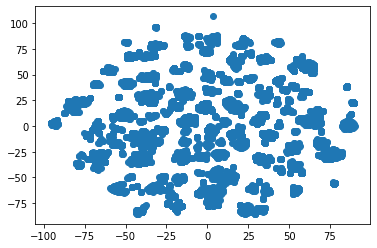

In [51]:
# plot reduced data
plt.scatter(reduced_X[:,0], reduced_X[:,1])
plt.show()

We have experimented with only 5,000 data points from our dataset (about 10%) because t-SNE takes a lot of time to run on the whole dataset. We have actually started from smaller number of data, trying 100, 500, and 1000 in the first place. Increasing the number each time, we have observed that there are more clusters appearing on the visualization. This might cause a problem in classification, but we are not sure how to explain this. However, having clusters in the data gives us a hope.

### Evaluation

We will evaluate predictions of each method in a same way: computing accuracy, precision, recall, and F1-score. Thus, it makes sense to write a wrapper method which accepts true labels and predictions, and then outputs evaluation results.

In [0]:
def evaluate(y_true, y_pred):
  print(f"Accuracy : {metrics.accuracy_score(y_true, y_pred)}")
  print(f"Precision: {metrics.precision_score(y_true, y_pred)}")
  print(f"Recall: {metrics.recall_score(y_true, y_pred)}")
  print(f"F1 score: {metrics.f1_score(y_true, y_pred)}")

### Logistic Regression

We start off with a logistic regression classifier. We have decided to implement this method from scratch. Basically, it requires us to optimize a cost function using stochastic gradient descent (SGD). Logistic regression is based on a simple regression but with sigmoid function applied to the outputs. The loss function is, therefore, different from that of regression.

In the following class we have included all the necessary functions for a logistic regression classifier. In training phase, we first compute the predictions with current weights. Then, we apply a sigmoid activation function and 

In [0]:
class BinaryLogisticRegression:
  def __init__(self, threshold=0.5):
    self.threshold = threshold
  
  def activation(self, x):
    return 1.0 / (1 + np.exp(-x))
  
  def predict(self, X, theta):
    z = np.dot(X, theta)
    return self.activation(z)
  
  def cost_function(self, X, y, theta):
    # get predictions
    h = self.predict(X, theta)
    # compute cost (average loss)
    L = (-np.dot(y, np.log(h)) - np.dot((1-y), np.log(1-h))) / len(y)
    return L
  
  def gradient_descent_step(self, X, y, theta, alpha):
    # get predictions
    predictions = self.predict(X, theta)
    # calculate gradient
    gradient = np.dot(X.T, predictions - y)
    # take average
    gradient /= len(y)
    # multiply by learning rate
    gradient *= alpha
    # update weights
    theta -= gradient
    
    return theta
  
  def train(self, X, y, theta, alpha, iterations):
    for i in range(iterations):
      theta = self.gradient_descent_step(X, y, theta, alpha)
      
    return theta
  
  def decision_boundary(self, prediction):
    return 1 if prediction >= self.threshold else 0
  
  def classify(self, predictions):
    vectorized_decision_boundary = np.vectorize(self.decision_boundary)
    return vectorized_decision_boundary(predictions).flatten()

In [0]:
# create an array of weights
theta = np.zeros((X.shape[-1],))
# select hyperparameters
alpha = 0.01
iterations = 3000
# initialize a logistic regresison classifier
lr_clf = BinaryLogisticRegression()

In [57]:
# train logistic regression classifier
theta = lr_clf.train(X_train[:100,:], y_train[:100], theta, alpha, iterations)
print(theta)

[ 0.4166587  -0.16552625 -0.01739688  0.05034492 -4.25784903 -0.7605382
 -0.25509244  0.33766478 -0.13077055  0.23089604  0.0381135 ]


In [59]:
# predict values
y_pred = lr_clf.predict(X_test[:100,:], theta)
# print(y_pred)

# classify
y_class = lr_clf.classify(y_pred)
print(y_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0
 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0]


In [60]:
evaluate(y_test[:100], y_class)

Accuracy : 0.62
Precision: 0.8461538461538461
Recall: 0.23404255319148937
F1 score: 0.36666666666666675


Logistic regression is pretty fast to train, however our implementation is probably not the best in terms of efficiency. The evaluation results are not great, with about 62% accuracy and low scores in recall and F1 score. However, precision is quite high, which means that it determines a collision with a pedestrian quite well.

### SVM classifier


In [0]:
# initialize an SVM classifier (with linear kernel)
svm_clf = svm.SVC(kernel='linear')
# train
svm_clf.fit(X_train, y_train)
# predict on test data
y_pred = svm_clf.predict(X_test)

In [62]:
evaluate(y_test, y_pred)

Accuracy : 0.757
Precision: 0.7212787212787213
Recall: 0.7771797631862217
F1 score: 0.7481865284974093


SVM classifier is way better in terms of evaluation. However, it takes a long time for training even on a reduced dataset of 10,000 data points. On average, SVM gets about 75% on all metrics, which is a lot compared to logistic regression classifier. Apart from that, we just use a linear kernel. Let's actually try a radial basis function kernel.

In [67]:
# initialize an SVM classifier (with rbf kernel)
svm_rbf_clf = svm.SVC(kernel='rbf')
# train
svm_rbf_clf.fit(X_train, y_train)
# predict on test data
y_pred = svm_rbf_clf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [68]:
evaluate(y_test, y_pred)

Accuracy : 0.793
Precision: 0.7646454265159301
Recall: 0.8008611410118407
F1 score: 0.7823343848580442


Trying RBF kernel gives an increase of about 5%. Moreover, it is empirically much faster in training than using a linear kernel.

### Random Forest Classifier

In [95]:
# intiialize a Random Forest classifier
rf_clf = RandomForestClassifier(max_features=8)
# train it on breast cancer data
rf_clf.fit(X_train, y_train)
# predict on test data
y_pred = rf_clf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [96]:
evaluate(y_test, y_pred)

Accuracy : 0.7915
Precision: 0.756
Recall: 0.813778256189451
F1 score: 0.7838258164852256


Random forest clasifier is a decision tree method. We hypothesize that it performs quite well on this data because the data is clustered (as observed in visualization). It is comparable to SVM with RBF kernel, while being a little bit faster. We have manually tried several hyperparameters of maximum number of features and came up with a value of 8.

### kNN

Let us employ k-fold cross validation to obtain the best hyperparameter *k*.

In [98]:
# try different values of k
for k in range(1, 10):
  knn_clf = KNeighborsClassifier(n_neighbors=k)
  scores = cross_val_score(knn_clf, X, y, cv = 5)
  print("k = %.3f, cross_val_score = %.4f"% (k, np.mean(scores)))

k = 1.000, cross_val_score = 0.7593
k = 2.000, cross_val_score = 0.7625
k = 3.000, cross_val_score = 0.7747
k = 4.000, cross_val_score = 0.7772
k = 5.000, cross_val_score = 0.7761
k = 6.000, cross_val_score = 0.7832
k = 7.000, cross_val_score = 0.7813
k = 8.000, cross_val_score = 0.7819
k = 9.000, cross_val_score = 0.7847


In [0]:
# initialize a kNN classifier with best value of k
knn_clf = KNeighborsClassifier(n_neighbors= 9)
# train it on breast cancer data
knn_clf.fit(X_train, y_train)
# predict on test data
y_pred = knn_clf.predict(X_test)

In [100]:
evaluate(y_test, y_pred)

Accuracy : 0.781
Precision: 0.7497456765005086
Recall: 0.7933261571582346
F1 score: 0.7709205020920502


k-Nearest Neighbors also performs pretty well on this task. It reaches about the same average evaluation score as the previous two models, while being a much simpler model.

### Neural networks

In [0]:
# initialize an MLP classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(30,30,30))
# train
mlp_clf.fit(X_train, y_train)
# predict
y_pred = mlp_clf.predict(X_test)

In [103]:
evaluate(y_test, y_pred)

Accuracy : 0.772
Precision: 0.7094774136403897
Recall: 0.8622174381054898
F1 score: 0.7784256559766763


A neural network does not outperform random forest and SVM in accuracy, but it shows a better score for recall. Let us try different number of neurons in each layer, and then increasing number of layers.

In [107]:
# initialize an MLP classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(128,128,128))
# train
mlp_clf.fit(X_train, y_train)
# predict
y_pred = mlp_clf.predict(X_test)
# evaluate
evaluate(y_test, y_pred)

Accuracy : 0.779
Precision: 0.7191719171917191
Recall: 0.860064585575888
F1 score: 0.7833333333333332


In [108]:
# initialize an MLP classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(32,64,32))
# train
mlp_clf.fit(X_train, y_train)
# predict
y_pred = mlp_clf.predict(X_test)
# evaluate
evaluate(y_test, y_pred)

Accuracy : 0.7855
Precision: 0.7376425855513308
Recall: 0.8353067814854682
F1 score: 0.7834427057041896


In [109]:
# initialize an MLP classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(32,64,128,64,32))
# train
mlp_clf.fit(X_train, y_train)
# predict
y_pred = mlp_clf.predict(X_test)
# evaluate
evaluate(y_test, y_pred)

Accuracy : 0.786
Precision: 0.7767955801104972
Recall: 0.7567276641550054
F1 score: 0.7666303162486368


In [110]:
# initialize an MLP classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(32,64,128,256,64))
# train
mlp_clf.fit(X_train, y_train)
# predict
y_pred = mlp_clf.predict(X_test)
# evaluate
evaluate(y_test, y_pred)

Accuracy : 0.7875
Precision: 0.7603305785123967
Recall: 0.7922497308934338
F1 score: 0.775962045334739


In [111]:
# initialize an MLP classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(64,128,128,128,64,64,64))
# train
mlp_clf.fit(X_train, y_train)
# predict
y_pred = mlp_clf.predict(X_test)
# evaluate
evaluate(y_test, y_pred)

Accuracy : 0.786
Precision: 0.7606659729448492
Recall: 0.7868675995694295
F1 score: 0.7735449735449735


As you can see, trying different configurations do not affect the scores that much, but the recall score decreases with deeper networks.

### LDA 

In [112]:
# initialize LDA classifier
lda_clf = LinearDiscriminantAnalysis()
# train LDA classifier
lda_clf.fit(X_train, y_train)
# predict values
y_pred = lda_clf.predict(X_test)
# evaluate
evaluate(y_test, y_pred)

Accuracy : 0.762
Precision: 0.7381703470031545
Recall: 0.7556512378902045
F1 score: 0.7468085106382977


### QDA

In [113]:
# initialize QDA classifier
qda_clf = QuadraticDiscriminantAnalysis()
# train QDA classifier
qda_clf.fit(X_train, y_train)
# predict values
y_pred = qda_clf.predict(X_test)
# evaluate
evaluate(y_test, y_pred)

Accuracy : 0.671
Precision: 0.5958952583156405
Recall: 0.9063509149623251
F1 score: 0.7190435525192143


LDA performs about the same as the previous models, with ~75% on all metrics. However, QDA has a much lower score (except for recall). This means that quadratic decision boundaries are not suited for the data we have.

## Conclusion

After preprocessing and analyzing the data on car accidents in Kazakhstan, we can conclude that we can classify car accidents into two categories (collisions with cars and collisions with pedestrians) with a relatively high accuracy (and other metrics). The best classifiers for this problem are random forest and SVM. However, LDA, kNN, and neural networks also achieve good results. Logistic regression and QDA were a little bit worse as shown by evaluation. 

## Limitations and further improvements

There are clearly many limitations to our study. One of them is that we have devoted too little for the classification itself. The reason for that is the difficulty of preprocessing the data. We had to manually inspect the features and design specific transformations to convert the data. 

We could have also added more features into the data. For instance, we had coordinates of each car accident. Adding some features, e.g. population of that location, distance from the centre etc. Experimenting with augmented features is a good way to analyze what is important in a problem and could possibly further improve the metrics in classification.

We have initially selected type of accident as a target variable. However, there are also different features which could have been classified, or even predicted with regression. An example of another setting is to predict the number of injured or dead people in a car accident (however this is probably an unbalanced situation, since most of the accidents have 1-3 injured and 0 dead people).